Car Model Predictor -Safwan Shaikh

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#import all the essential and heavy Libraries for this training model
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
import joblib
import gradio as gr


In [ ]:
#Dataset Path + DataFrame
import os
import pandas as pd

dataset_path = "/content/drive/MyDrive/archive/Cars Dataset"

# Collect all image paths from train and test folders
image_files = []

for folder in ['train', 'test']:
    image_folder = os.path.join(dataset_path, folder)
    for label in sorted(os.listdir(image_folder)):
        class_folder = os.path.join(image_folder, label)
        if os.path.isdir(class_folder):
            for file in os.listdir(class_folder):
                image_files.append(os.path.join(class_folder, file))

# Create a DataFrame
image_files_df = pd.DataFrame(image_files, columns=['file_path'])
print("Total images found:", len(image_files_df))
print(image_files_df.head())


In [ ]:
#     Recreate DataFrame
import pandas as pd
import os

dataset_path = "/content/drive/MyDrive/archive/Cars Dataset"
image_folder = os.path.join(dataset_path, "train")

image_paths = []
labels = []
image_folder = os.path.join(dataset_path, "train")

for label in sorted(os.listdir(image_folder)):  # image_folder points to /train
    folder = os.path.join(image_folder, label)
    if os.path.isdir(folder):
        for img_name in os.listdir(folder):
            img_path = os.path.join(folder, img_name)
            image_paths.append(img_path)
            labels.append(label)

train_df = pd.DataFrame({
    'file_path': image_paths,
    'label1': labels
})

print(train_df.head())
print("Total images:", len(train_df))


In [ ]:
#Transform + Dataset Class + DataLoader
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

class CarDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        fp = self.df.iloc[idx]["file_path"]
        label = self.df.iloc[idx]["label1"]
        img = Image.open(fp).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

train_dataset = CarDataset(train_df, transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [ ]:
#visually checking if the above code is actually printing or oding something
batch = next(iter(train_loader))
print(type(batch))
print(len(batch))
print(batch[0].shape)  # shape of image tensor batch
print(batch[1][:5])    # first 5 labels in the batch


<class 'list'>
2
torch.Size([32, 3, 224, 224])
('Mahindra Scorpio', 'Swift', 'Hyundai Creta', 'Toyota Innova', 'Tata Safari')


In [ ]:

# resnet model initialization
import torch
import torch.nn as nn
from torchvision import models

# Load pretrained ResNet18
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Remove the final classification layer
model.fc = nn.Identity()

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

model.eval()
print("Model ready on:", device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 193MB/s]


Model ready on: cuda


In [ ]:
#re uploading the extract for the training model
from tqdm import tqdm

all_features = []
all_labels = []

with torch.no_grad():
    for imgs, batch_labels in tqdm(train_loader, desc="Extracting Features"):
        imgs = imgs.to(device)
        feats = model(imgs).cpu().numpy()
        all_features.append(feats)
        all_labels.extend(batch_labels)

all_features = np.vstack(all_features)
all_labels = np.array(all_labels)

print(all_features.shape, all_labels.shape)


Extracting Features: 100%|██████████| 105/105 [17:14<00:00,  9.85s/it]

(3352, 512) (3352,)


In [ ]:
#Feature Extraction

import numpy as np

# Put model in eval mode
model.eval()

# Store extracted features and labels
all_features = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(train_loader, desc="Extracting Features"):
        imgs = imgs.to(device)

        # Pass through ResNet18
        features = model(imgs)

        # Move to CPU + convert to numpy
        features = features.cpu().numpy()

        all_features.append(features)
        all_labels.extend(labels)

# Combine all batches into one array
all_features = np.vstack(all_features)
all_labels = np.array(all_labels)

print("Feature matrix shape:", all_features.shape)
print("Number of labels:", len(all_labels))


In [ ]:
from tqdm import tqdm



In [ ]:
np.save("/content/drive/MyDrive/car_features.npy", all_features)
np.save("/content/drive/MyDrive/car_labels.npy", all_labels)


In [ ]:
import numpy as np

all_features = np.load("/content/drive/MyDrive/car_features.npy")
all_labels = np.load("/content/drive/MyDrive/car_labels.npy")

print(all_features.shape, all_labels.shape)


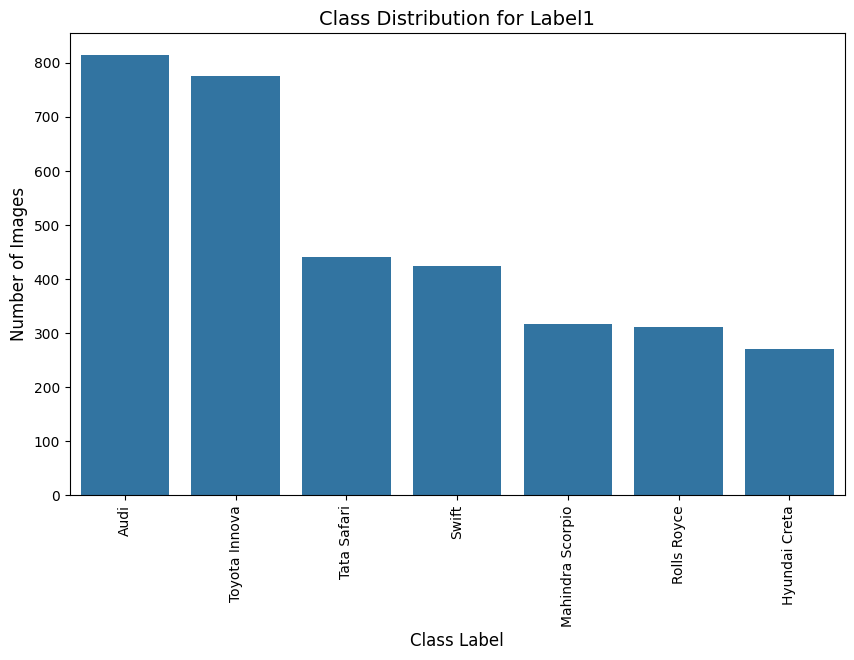

In [ ]:
import seaborn as sns

# Get the number of images for each class in label1
class_counts = train_df['label1'].value_counts()

# Create a bar plot to visualize the class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Class Label', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Class Distribution for Label1', fontsize=14)
plt.xticks(rotation=90)
plt.show()


Transform + Device + Load ResNet18 + Load PCA, KNN, LabelEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import joblib

# Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load ResNet model
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Identity()
model = model.to(device)
model.eval()

# Load saved embeddings + models
all_features = np.load("/content/drive/MyDrive/car_features.npy")
all_labels = np.load("/content/drive/MyDrive/car_labels.npy")
pca = joblib.load("/content/drive/MyDrive/car_pca_model.pkl")
knn_pca = joblib.load("/content/drive/MyDrive/car_knn_model.pkl")
le = joblib.load("/content/drive/MyDrive/label_encoder.pkl")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Check if the devie is running on CPU or GPU

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


REDEFINE predict_image()

In [ ]:
from PIL import Image
import numpy as np

def predict_image(file_path):
    img = Image.open(file_path).convert("RGB")
    img_t = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        feat = model(img_t).cpu().numpy()
        feat_pca = pca.transform(feat)

    pred = knn_pca.predict(feat_pca)[0]
    return le.inverse_transform([pred])[0]


In [ ]:
#KNN CLASSIFIER (Make/Model Recognition)
#STEP 1 — Encode labels (KNN needs numbers, not strings)
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
labels_encoded = le.fit_transform(all_labels)

print("Number of classes:", len(le.classes_))
print("Example mapping:", list(zip(le.classes_[:10], labels_encoded[:10])))


Number of classes: 7
Example mapping: [(np.str_('Audi'), np.int64(4)), (np.str_('Hyundai Creta'), np.int64(6)), (np.str_('Mahindra Scorpio'), np.int64(2)), (np.str_('Rolls Royce'), np.int64(0)), (np.str_('Swift'), np.int64(6)), (np.str_('Tata Safari'), np.int64(6)), (np.str_('Toyota Innova'), np.int64(4))]


In [ ]:
# Step 2  - train the Actual KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Create the classifier
knn = KNeighborsClassifier(
    n_neighbors=3,        # Try 3 neighbors
    metric='cosine',      # Cosine works best for image embeddings
    weights='distance'    # Closer neighbors matter more
)

# Train on the full dataset
knn.fit(all_features, labels_encoded)

# Predict on the same features (we'll do real test split later)
preds = knn.predict(all_features)

# Report
print(classification_report(labels_encoded, preds))


In [ ]:
#STEP 3 — Train/Test Split BEFORE KNN
#this split will dovode my dataset into : 80% training KNN + 20% testing KNN
#stratify var will keep all the car brands balanced
from sklearn.model_selection import train_test_split

# Split the features + labels into real train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    all_features,
    labels_encoded,
    test_size=0.2,       # 20% for testing
    random_state=42,     # repeatable split
    stratify=labels_encoded  # keep class balance
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (2681, 512)
Test size: (671, 512)


In [ ]:
#STEP 4 — Re-train KNN on the training set
knn = KNeighborsClassifier(
    n_neighbors=3,
    metric='cosine',
    weights='distance'
)

knn.fit(X_train, y_train)

preds_test = knn.predict(X_test)

print(classification_report(y_test, preds_test))


Generates Random images of Rolls Royce everytime I run it

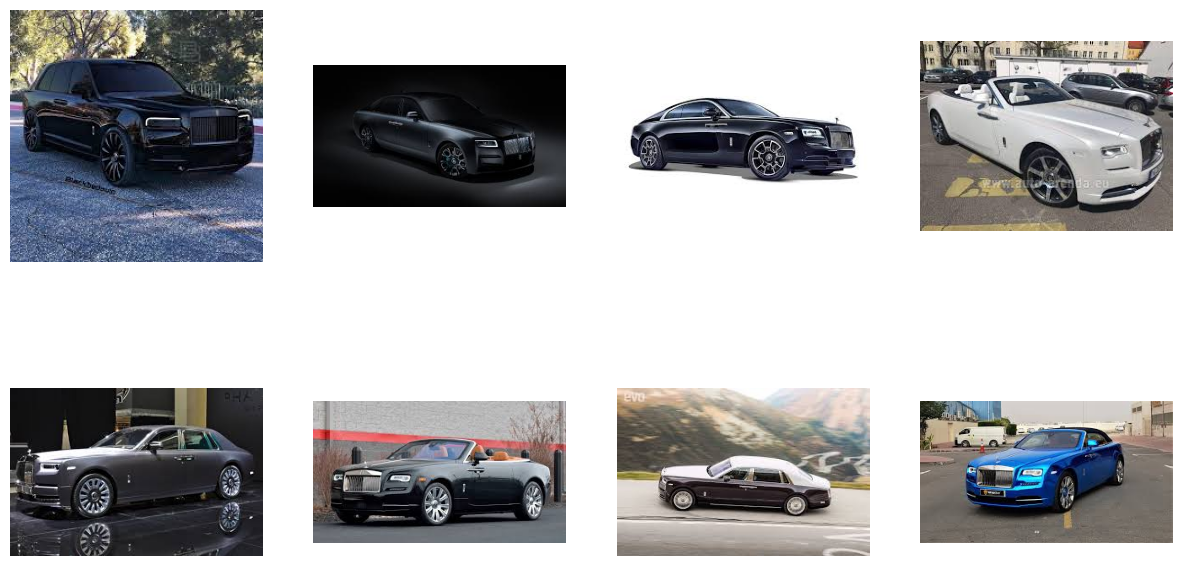

In [ ]:
import random
import matplotlib.pyplot as plt

rr_folder = "/content/drive/MyDrive/archive/Cars Dataset/train/Rolls Royce"

# list RR images
rr_images = [os.path.join(rr_folder, f) for f in os.listdir(rr_folder)]

# show 8 random ones
plt.figure(figsize=(15, 8))
for i in range(8):
    img = Image.open(random.choice(rr_images))
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.axis("off")
plt.show()


In [ ]:
#Run PCA + KNN
#This is garbage-in → garbage-out.
#OPTION C — Merge Rolls Royce into a generic class

from sklearn.decomposition import PCA

pca = PCA(n_components=128)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

knn_pca = KNeighborsClassifier(
    n_neighbors=3,
    metric='cosine',
    weights='distance'
)

knn_pca.fit(X_train_pca, y_train)
preds_pca = knn_pca.predict(X_test_pca)

print(classification_report(y_test, preds_pca))


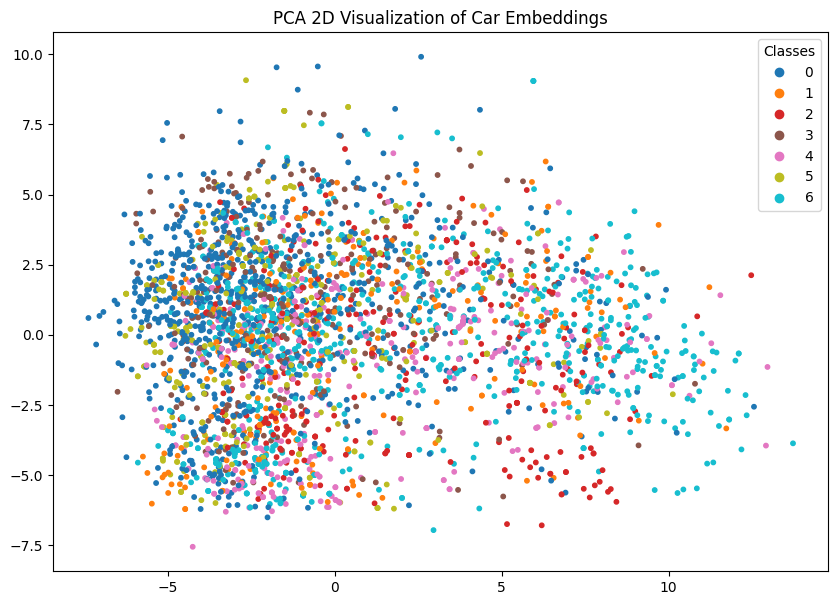

In [ ]:
#C) VISUALIZE EMBEDDINGS (PCA-2D + t-SNE)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca2 = PCA(n_components=2)
X_vis = pca2.fit_transform(all_features)

plt.figure(figsize=(10,7))
scatter = plt.scatter(X_vis[:,0], X_vis[:,1], c=labels_encoded, cmap='tab10', s=10)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("PCA 2D Visualization of Car Embeddings")
plt.show()


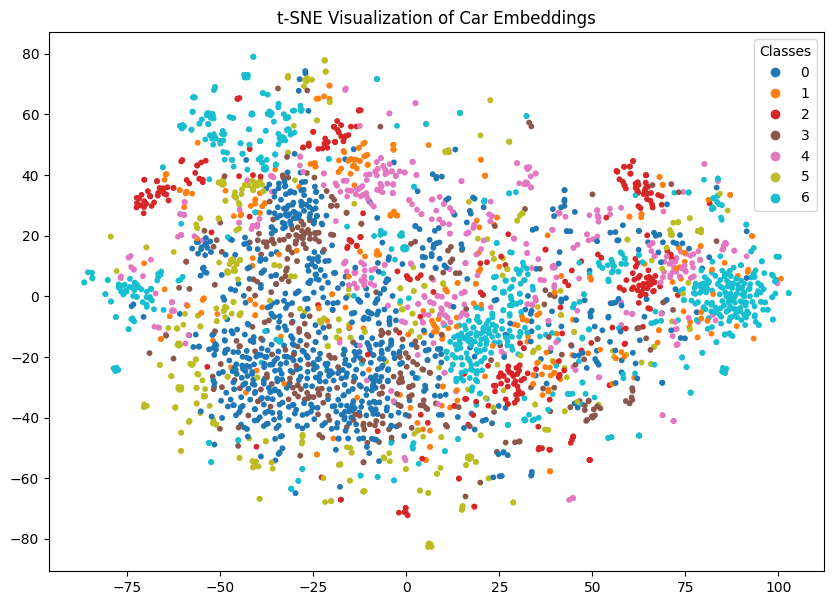

In [ ]:
#t-SNE (more expressive)
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
X_tsne = tsne.fit_transform(all_features)

plt.figure(figsize=(10,7))
scatter = plt.scatter(X_tsne[:,0], X_tsne[:,1], c=labels_encoded, cmap='tab10', s=10)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("t-SNE Visualization of Car Embeddings")
plt.show()


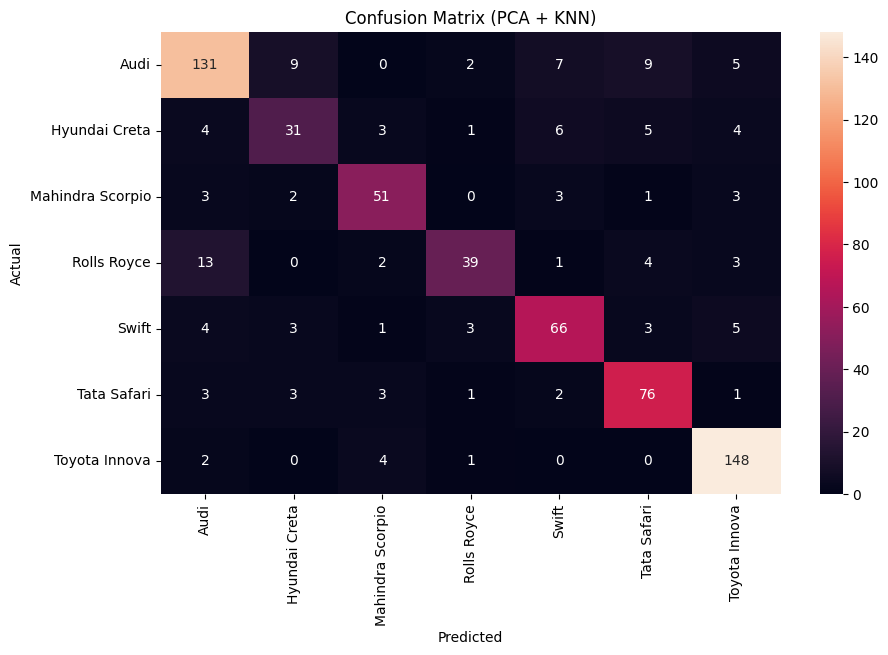

In [ ]:

cm = confusion_matrix(y_test, preds_pca)

plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (PCA + KNN)")
plt.show()


In [ ]:
# D) PREDICT ON A NEW IMAGE
def predict_image(file_path):
    img = Image.open(file_path).convert("RGB")
    img_t = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        feat = model(img_t).cpu().numpy()
        feat_pca = pca.transform(feat)   # apply your PCA model

    pred_encoded = knn_pca.predict(feat_pca)[0]
    pred_label = le.inverse_transform([pred_encoded])[0]
    return pred_label


Now Test Prediction

In [ ]:
#Testing
test_img = "/content/drive/MyDrive/archive/Cars Dataset/test/Audi/1000.jpg"
print("Prediction:", predict_image(test_img))


Prediction: Audi


Load pre trained ResNet18 for Feature Extraction

In [ ]:
import torch.nn as nn
from torchvision import models

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Identity()
model = model.to(device)
model.eval()


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import joblib

# Encode labels
le = LabelEncoder()
labels_encoded = le.fit_transform(all_labels)

# Train PCA again
pca = PCA(n_components=128)
features_pca = pca.fit_transform(all_features)

# Train KNN again
knn_pca = KNeighborsClassifier(
    n_neighbors=3,
    metric='cosine',
    weights='distance'
)
knn_pca.fit(features_pca, labels_encoded)

# SAVE MODELS
joblib.dump(pca, "/content/drive/MyDrive/car_pca_model.pkl")
joblib.dump(knn_pca, "/content/drive/MyDrive/car_knn_model.pkl")
joblib.dump(le, "/content/drive/MyDrive/label_encoder.pkl")

print("Models saved.")


Models saved.


Save PCA + KNN models

In [ ]:
import joblib

pca = joblib.load("/content/drive/MyDrive/car_pca_model.pkl")
knn_pca = joblib.load("/content/drive/MyDrive/car_knn_model.pkl")
le = joblib.load("/content/drive/MyDrive/label_encoder.pkl")

print("Models loaded successfully")


Models loaded successfully


In [ ]:
!pip install gradio

GRADIO UI

In [ ]:
import gradio as gr

def gradio_predict(img):
    # Convert the uploaded image (PIL) into the same format predict_image expects
    img.save("temp_upload.jpg")
    pred_label = predict_image("temp_upload.jpg")
    return pred_label

interface = gr.Interface(
    fn=gradio_predict,
    inputs=gr.Image(type="pil"),
    outputs=gr.Textbox(),
    title="Car Make Recognition",
    description="Upload a car image and the model will predict the make."
)

interface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9b3ac9fa7f68f0695e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
